In [25]:
import numpy as np

class Learner():
    def __init__(self):
        self.bid = np.linspace(1.0, 10.0, 10)
        
        self.t = 0 
        
        self.n_arms = 10 

        self.rewards_per_arm = x = [[] for i in range(self.n_arms)]
        self.collected_rewards = []
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)

class TS_Learner(Learner):
    def __init__(self):
        super().__init__()
        self.beta_parameters = np.ones((self.n_arms, 2))

    def pull_arm(self):
        return np.argmax(np.random.beta(self.beta_parameters[: , 0], self.beta_parameters[:, 1]))

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm , 1] + 1 - reward

In [2]:
opt_bids = [5.92895410817995,  2.682396521822428,  2.9540452274843294]
opt_price = 6.541655879916771

In [30]:
from environment import Environment
price = 5.0

T = 365
env = Environment()
regret = []
ts_learner = TS_Learner()
ts_rewards_per_experiment = []

for t in range(T):
    #TS learner 
    bid = ts_learner.pull_arm()
    bids = [bid,bid,bid]
    reward = env.round(bids,price)
    ts_learner.update(int(bid), sum(reward)/10000)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
0.32475694722574927
9
[[1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.32475695 1.67524305]]
0.403696726641473
7
[[1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.40369673 1.59630327]
 [1.         1.        ]
 [1.32475695 1.67524305]]
0.46682069929537845
4
[[1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.4668207  1.5331793 ]
 [1.         1.        ]
 [1.         1.        ]
 [1.40369673 1.59630327]
 [1.         1.        ]
 [1.32475695 1.67524305]]
0.2847509914479204
1
[[1.         1.        ]
 [1.28475099 1.71524901]
 [1.         1.      

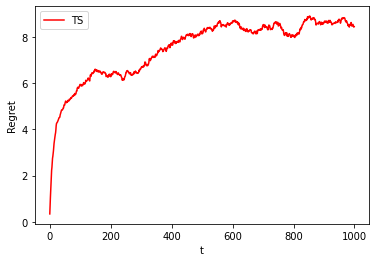

In [7]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)) , 'r')
plt.legend(["TS" ])
plt.show()